### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [40]:
import sys  
sys.path.insert(0, '../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 0

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [41]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 20],
    'batch_size': ["interval-int", 100, 200],
    #'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model creation function

In [42]:
def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Experiment parameters

In [43]:
DIRECTORY = "Current_tests/"+time.strftime("%H_%M_%S", time.localtime())

SPARSE_PARAMS = [2, 0.0, "gradient_descent"]

BUDGETS = [1000]

### Optimization

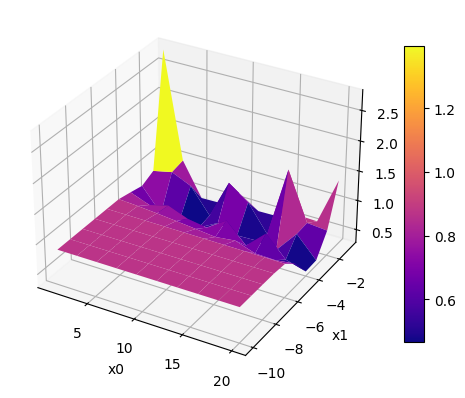

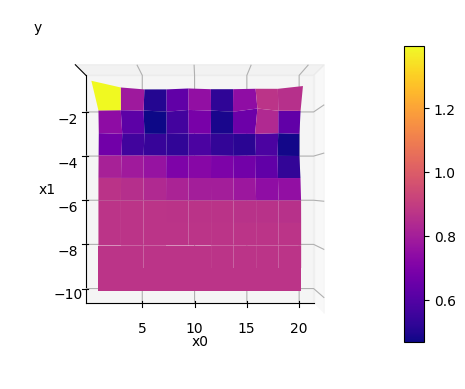

In [44]:
# os.mkdir(DIRECTORY)

# f = open(DIRECTORY+"/configurations.txt", "a")
# f.write("Dimension of hyperparameter space: " +
#         str(len(hyperparameterspace)) + "\n")
# for key in hyperparameterspace.keys():
#     f.write("\n" + key + ": " + str(hyperparameterspace[key]))
# f.write("\n\nSparse grid degree: " + str(SPARSE_PARAMS[0]))
# f.write("\nSparse grid adaptivity param: " + str(SPARSE_PARAMS[1]))
# f.write("\nSparse grid optimization alg: " + str(SPARSE_PARAMS[2]))
# f.write("\nBUDGETS: " + str(BUDGETS))
# f.close()


################## MODEL AND FUNCTION DEFINITION ####################
CV = 2
dataset = HPO.Dataset(task_id=233211)

def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

    kfold = KFold(n_splits=CV)

    split = (kfold.split(dataset.get_X(), dataset.get_Y()))

    values = []

    numeric_features = [not x for x in dataset.get_categorical_indicator()]
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(
                handle_unknown="infrequent_if_exist", sparse_output=False)),
            # ("selector", SelectPercentile(chi2, percentile=50)),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer,
                dataset.get_categorical_indicator()),
        ]
    )

    for i, (train_index, test_index) in enumerate(split):

        if deterministic:
            reset_seeds()

        X_train = dataset.get_X()[train_index]
        Y_train = dataset.get_Y()[train_index]

        X_val = dataset.get_X()[test_index]
        Y_val = dataset.get_Y()[test_index]

        preprocessor.fit(X_train, Y_train)

        X_train = preprocessor.transform(X_train)
        X_val = preprocessor.transform(X_val)

        regressor = KerasRegressor(model=create_model,
                                    learning_rate=learning_rate,
                                    input_dim=len(
                                        X_train[0]),
                                    number_layers=number_of_layers,
                                    neurons_per_layer=neurons_per_layer,
                                    verbose=0)

        regressor = TransformedTargetRegressor(regressor=regressor,
                                                transformer=StandardScaler())

        regressor.fit(X_train, Y_train, epochs=int(epochs),
                        batch_size=int(batch_size), shuffle=False)

        Y_predicted = regressor.predict(X_val)
        # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
        error = sklearn.metrics.mean_absolute_percentage_error(
            Y_predicted, Y_val)
        values.append(error)

        del regressor
        K.clear_session()

    result = sum(values)/len(values)
    return result


class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(
            len(hyperparameterspace.keys()))

    def eval(self, x):
        # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = (HPO.from_standard(
            hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

        batch_size = (HPO.from_standard(
            hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

        # HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
        model_learning_rate = 0.0001
        #                  0], hyperparameterspace_special["learning_rate"][1], x[2])

        number_of_layers = 1  # int(HPO.from_standard(
        # hyperparameterspace_special["number_layers"][0], hyperparameterspace_special["number_layers"][1], x[3]))

        neurons_per_layer = 30  # int(HPO.from_standard(
        # hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)


resolution = 10

x = np.linspace(1, 20, resolution)
y = np.logspace(-10, -1, resolution)

X, Y = np.meshgrid(x, y)

Z = np.zeros((resolution, resolution))

for i in range(resolution):
    for j in range(resolution):
        Z[i][j] = evaluate_model(X[i][j], 100, Y[i][j], 1, 30)

for i in range(len(Y)):
    for j in range(len(Y[0])):
        Y[i][j] = np.log10(Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_normal.pgf",bbox_inches='tight' )
plt.show()


fig = plt.figure()
ax = plt.axes(projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
ax.set_zticks([])
ax.view_init(90, 270)
fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_above.pgf",bbox_inches='tight' )
plt.show()

# #### For each dataset: run models with different budget #####
# for BUDGET in BUDGETS:

#     print("\n################################################## Current Budget:",
#             BUDGET, "##################################################")

#     ########################### SPARSE OPT ############################


#     print("\nPerforming sparse search")

#     f = ExampleFunction()
#     dataset = HPO.Dataset([], [])

#     optimization = HPO.SparseGridSearchOptimization(
#         dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=SPARSE_PARAMS[0], adaptivity=SPARSE_PARAMS[1], optimizer=SPARSE_PARAMS[2])

#     result = optimization.fit()

#     print("Best score with Sparse Search:",
#             result[0][1], "optimized:", result[0][3])


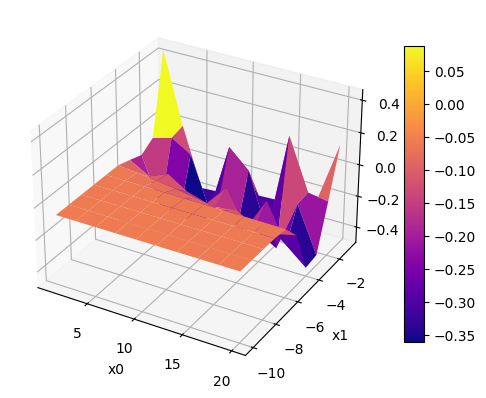

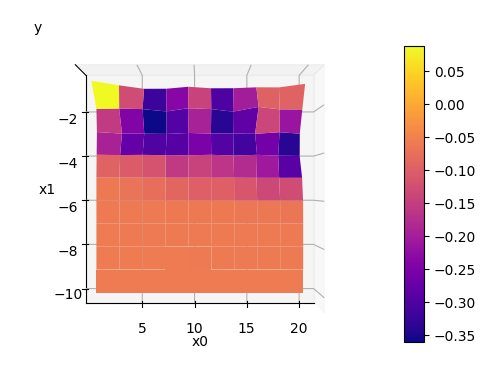

In [45]:
for i in range(len(Z)):
    for j in range(len(Z[0])):
        Z[i][j] = np.log10(Z[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_normal.pgf",bbox_inches='tight' )
plt.show()


fig = plt.figure()
ax = plt.axes(projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('y')
ax.set_zticks([])
ax.view_init(90, 270)
fig.colorbar(surface, shrink=0.8, aspect=15)
# plt.savefig("./Testfunctions/Rastrigin_above.pgf",bbox_inches='tight' )
plt.show()